# Imports

In [132]:
import os
import umap
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from typing import Callable, Any, Sequence
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.stats import entropy

In [2]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
ID_TO_LABEL = {0: "negative", 1: "neutral", 2: "positive"}
LABEL_TO_ID = {v: k for k, v in ID_TO_LABEL.items()}

In [42]:
Y_train_labels_str = pd.read_csv('training.csv')['label'].values
Y_train = jnp.array([label2id[label] for label in Y_train_labels_str])
print(Y_train.shape)

(102097,)


# UMAP Visualization of Main-Classifier Embeddings



In [43]:
def plot_umap_colab(embeddings, labels,
                    n_components=2, title_suffix="",
                    n_neighbors=15, min_dist=0.1,
                    num_classes_for_legend=3,
                    class_name_map=None,
                    color_override_map=None):

    effective_n_neighbors = n_neighbors
    reducer = umap.UMAP(
        n_neighbors=effective_n_neighbors, min_dist=min_dist, n_components=n_components,
        random_state=42, metric='cosine'
    )
    try:
        embedding_umap = reducer.fit_transform(embeddings)
    except Exception as e:
        print(f"Error during UMAP transformation: {e}"); return

    plt.figure(figsize=(8, 7) if n_components == 2 else (14, 12))

    unique_labels = np.unique(labels)
    default_color_for_unmapped = 'gray'

    point_colors_for_scatter = None
    cmap_for_plot = None
    legend_details = []

    standard_tri_class_colors = {0: 'red', 1: 'blue', 2: 'darkgreen'}

    sorted_unique_labels = sorted(list(unique_labels))
    for label_val in sorted_unique_labels:
        name = class_name_map.get(label_val, f"Class {label_val}") if class_name_map else f"Class {label_val}"
        color = standard_tri_class_colors[label_val]
        legend_details.append({'original_label': label_val, 'name': name, 'color': color})

    ax = None
    scatter_args = {'s': 25, 'alpha': 0.5}

    actual_point_colors = [standard_tri_class_colors.get(int(l), default_color_for_unmapped) for l in labels]

    ax = plt.gca()
    scatter_plot = ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=actual_point_colors, **scatter_args)
    plt.title(f'UMAP projection {title_suffix}', fontsize=20)
    plt.xlabel('UMAP Component 1', fontsize=16)
    plt.ylabel('UMAP Component 2', fontsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=item['color'], markersize=8, label=item['name'])
        for item in legend_details
    ]
    ax.legend(handles=handles, title="Classes", fontsize=18, title_fontsize=18)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


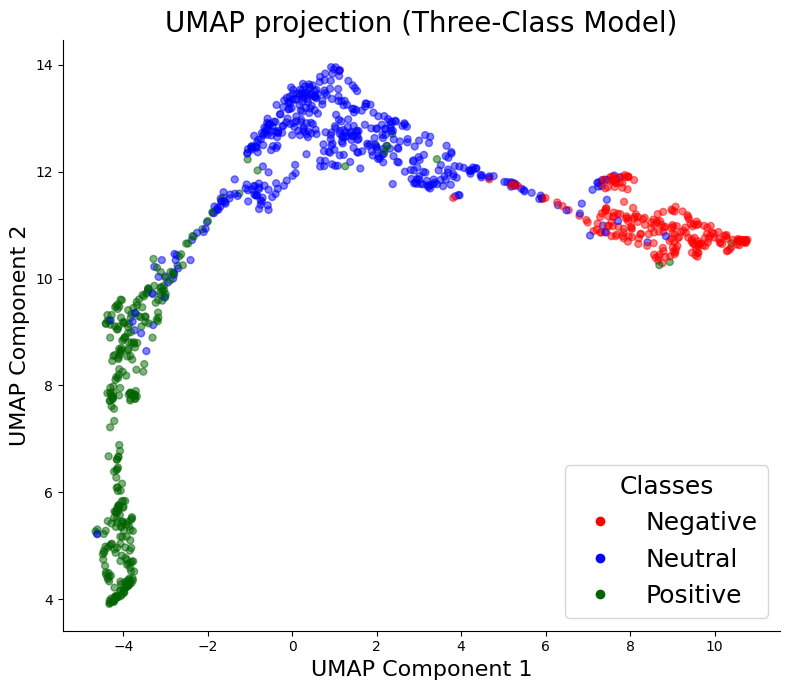

In [45]:
N_NEIGHBORS = 100
MIN_DIST = 0.05

X_embeddings_train, Y_labels_train, num_classes_found = np.load(f"train_outputsNeuNP.npz")['embeddings'][:1000,:], Y_train[:1000], 3

tri_class_names = {0: "Negative", 1: "Neutral", 2: "Positive"}

plot_umap_colab(
    X_embeddings_train,
    Y_labels_train,
    n_components=2,
    title_suffix="(Three-Class Model)",
    n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST,
    num_classes_for_legend=num_classes_found,
    class_name_map=tri_class_names,
    color_override_map=None
)

# Visualization of Model Confidence vs Accuracy

In [63]:
def get_error_details_with_experts(tri_class_probs, true_labels,
                                   expert_pos_probs, expert_neg_probs, expert_neu_probs):

    original_predictions = np.argmax(tri_class_probs, axis=1)
    confidences_of_predictions = np.max(tri_class_probs, axis=1)

    incorrect_mask = original_predictions != true_labels

    confidences_of_errors = confidences_of_predictions[incorrect_mask]
    predicted_labels_of_errors = original_predictions[incorrect_mask]
    true_labels_of_errors = true_labels[incorrect_mask]
    expert_pos_probs_errors = expert_pos_probs[incorrect_mask]
    expert_neg_probs_errors = expert_neg_probs[incorrect_mask]
    expert_neu_probs_errors = expert_neu_probs[incorrect_mask]

    num_total_samples = len(true_labels)
    num_errors = np.sum(incorrect_mask)

    print(f"\nTotal samples: {num_total_samples}")
    print(f"Number of incorrect predictions by base model: {num_errors}")
    print(f"Base model accuracy: {(1 - num_errors / num_total_samples) * 100:.2f}%")

    return (confidences_of_predictions, original_predictions, true_labels, confidences_of_errors, predicted_labels_of_errors, true_labels_of_errors,
            expert_pos_probs_errors, expert_neg_probs_errors, expert_neu_probs_errors)

def plot_confidence_accuracy_histogram(
    all_confidences,
    all_original_predictions,
    all_true_labels,
    num_bins=20,
    use_log_x_scale=False
):

    is_correct = (all_original_predictions == all_true_labels)

    min_conf_data = np.min(all_confidences) if len(all_confidences) > 0 else 1/3
    max_conf_data = np.max(all_confidences) if len(all_confidences) > 0 else 1.0
    bins = np.linspace(min_conf_data, max_conf_data, num_bins + 1)

    bin_accuracies = []
    bin_counts = []
    bin_centers = []

    for i in range(num_bins):
        bin_low = bins[i]
        bin_high = bins[i+1]
        bin_center = (bin_low + bin_high) / 2.0
        bin_centers.append(bin_center)

        in_bin_mask = (all_confidences >= bin_low) & (all_confidences < bin_high)
        if i == num_bins - 1:
            in_bin_mask = (all_confidences >= bin_low) & (all_confidences <= bin_high)

        correct_in_bin = np.sum(is_correct[in_bin_mask])
        total_in_bin = np.sum(in_bin_mask)

        bin_counts.append(total_in_bin)
        if total_in_bin > 0:
            accuracy = correct_in_bin / total_in_bin
            bin_accuracies.append(accuracy)
        else:
            bin_accuracies.append(0.0)

    fig, ax = plt.subplots(figsize=(12, 7))
    cmap = cm.get_cmap('Greens')
    norm = mcolors.Normalize(vmin=0, vmax=1)
    bar_colors = [cmap(norm(acc)) for acc in bin_accuracies]

    ax.bar(bin_centers, bin_accuracies, width=(bins[1]-bins[0])*0.9,
           color=bar_colors,
           alpha=0.95,
           edgecolor='black')

    ax.set_xlabel('$M_{orig}$ prediction confidence', fontsize=20)
    ax.set_ylabel('Accuracy', color='black', fontsize=20)
    ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_ylim(0, 1.05)

    plt.title('Base Model Accuracy vs. Confidence', fontsize=28)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.show()


Total samples: 102097
Number of incorrect predictions by base model: 7594
Base model accuracy: 92.56%


<ipython-input-63-de066023857a>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greens')


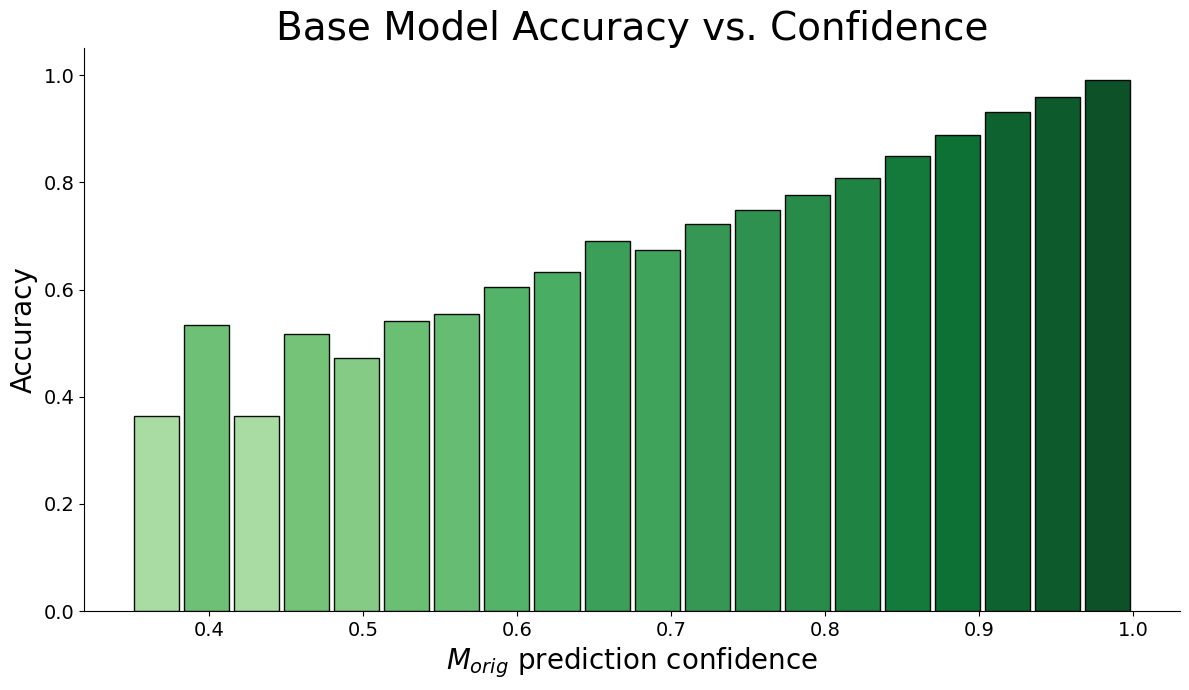

In [64]:
true_labels = Y_train
tri_class_probs = np.asarray(jax.nn.softmax(np.load(f"train_outputsNeuNP.npz")['logits'], axis=-1))
expert_neu_probs = np.asarray(jax.nn.softmax(np.load(f"train_outputsNeunNeu.npz")['logits'], axis=-1))
expert_neg_probs = np.asarray(jax.nn.softmax(np.load(f"train_outputsNnN.npz")['logits'], axis=-1))
expert_pos_probs = np.asarray(jax.nn.softmax(np.load(f"train_outputsPnP.npz")['logits'], axis=-1))


(all_confidences, all_original_predictions, all_true_labels_for_plot,
  confidences_of_errors, predicted_labels_of_errors, true_labels_of_errors,
  expert_pos_probs_errors, expert_neg_probs_errors, expert_neu_probs_errors
) = get_error_details_with_experts(
    tri_class_probs, true_labels,
    expert_pos_probs, expert_neg_probs, expert_neu_probs
)

plot_confidence_accuracy_histogram(
    all_confidences,
    all_original_predictions,
    all_true_labels_for_plot,
    num_bins=20,
    use_log_x_scale=False
)

# Helper Functions & Data Loading

In [107]:
#@title Helper Functions
def custom_score_jax(predicted_labels: jnp.ndarray, true_labels: jnp.ndarray) -> jnp.ndarray:
    true_labels_mod = true_labels - 1
    predicted_labels_mod = predicted_labels - 1
    mean_abs_diff = jnp.mean(jnp.abs(true_labels_mod.astype(jnp.float32) - predicted_labels_mod.astype(jnp.float32)))
    score = 0.5 * (2.0 - mean_abs_diff)
    return score

def custom_score_jax(predicted_labels: jnp.ndarray, true_labels: jnp.ndarray) -> jnp.ndarray:
    true_labels_mod = true_labels - 1
    predicted_labels_mod = predicted_labels - 1
    mean_abs_diff = jnp.mean(jnp.abs(true_labels_mod.astype(jnp.float32) - predicted_labels_mod.astype(jnp.float32)))
    score = 0.5 * (2.0 - mean_abs_diff)
    return jnp.mean(predicted_labels == true_labels)

def individual_custom_score_mad(predicted_label: int, true_label: int) -> float:
    return custom_score_jax(predicted_label, true_label)

def binary_entropy(p: np.ndarray) -> np.ndarray:
    epsilon = 1e-9
    p_clipped = np.clip(p, epsilon, 1.0 - epsilon)
    entropy_val = -p_clipped * np.log2(p_clipped) - (1.0 - p_clipped) * np.log2(1.0 - p_clipped)
    entropy_val = np.where((p < epsilon) | (p > 1.0 - epsilon), 0.0, entropy_val)
    return entropy_val

In [108]:
#@title Load Train Data
try:
    tri_class_probs_data = np.asarray(jax.nn.softmax(np.load(f"train_outputsNeuNP.npz")['logits'], axis=-1))
    expert_neutral_probs_data = np.asarray(jax.nn.softmax(np.load(f"train_outputsNeunNeu.npz")['logits'], axis=-1)) # 0:Not Neutral, 1:Neutral
    expert_negative_probs_data = np.asarray(jax.nn.softmax(np.load(f"train_outputsNnN.npz")['logits'], axis=-1))    # 0:Not Negative, 1:Negative
    expert_positive_probs_data = np.asarray(jax.nn.softmax(np.load(f"train_outputsPnP.npz")['logits'], axis=-1))    # 0:Not Positive, 1:Positive
    print(f"Data loaded successfully. Number of samples: {len(tri_class_probs_data)}")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure your '.npz' files are in the correct location.")
    exit()

# Test Data
try:
    tri_class_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNeuNP.npz")['logits'], axis=-1))
    expert_neutral_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNeunNeu.npz")['logits'], axis=-1))
    expert_negative_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNnN.npz")['logits'], axis=-1))
    expert_positive_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsPnP.npz")['logits'], axis=-1))
    print(f"Test data loaded successfully. Number of samples: {len(tri_class_probs_data_test)}")
except FileNotFoundError as e:
    print(f"Error loading test data files: {e}")
    print("Please ensure your 'test_outputs...' .npz files are in the correct location.")
    exit()

Data loaded successfully. Number of samples: 102097
Test data loaded successfully. Number of samples: 11951


# Baseline 2: Fixed Threshold Confidence Ensembling

In [113]:
#@title Code for Sweeping
original_tri_class_predictions = np.argmax(tri_class_probs_data, axis=1)
top_tri_probs_all = np.max(tri_class_probs_data, axis=1)

conf_tri_class_values = np.round(np.arange(0.3, 1.01, 0.05), 2)
expert_conf_values = np.round(np.arange(0.1, 1.01, 0.05), 2)

threshold_search_space = {
    'CONFIDENCE_THRESHOLD_TRI_CLASS': list(conf_tri_class_values),
    'EXPERT_CONFIDENCE_THRESHOLD':    list(expert_conf_values)
}


best_overall_custom_score = -float('inf')
best_thresholds = {}
best_num_changed = 0
best_frac_correct_relabel = 0.0

threshold_names = list(threshold_search_space.keys())
threshold_value_combinations = list(product(*(threshold_search_space[key] for key in threshold_names)))

print(f"\nStarting simple hyperparameter sweep with {len(threshold_value_combinations)} combinations.")
pbar = tqdm(total=len(threshold_value_combinations))

for thresh_values_tuple in threshold_value_combinations:
    # Get current threshold config
    current_conf_tri_thresh = thresh_values_tuple[threshold_names.index('CONFIDENCE_THRESHOLD_TRI_CLASS')]
    current_exp_conf_thresh = thresh_values_tuple[threshold_names.index('EXPERT_CONFIDENCE_THRESHOLD')]

    # Identify samples with low-confidence tri-class predictions
    low_confidence_mask = top_tri_probs_all < current_conf_tri_thresh

    # Get expert decisions vectorized using the CURRENT EXPERT_CONFIDENCE_THRESHOLD
    is_neutral_expert_pred_all = expert_neutral_probs_data[:, 1] > current_exp_conf_thresh
    is_not_neutral_expert_pred_all = expert_neutral_probs_data[:, 0] > current_exp_conf_thresh
    is_negative_expert_pred_all = expert_negative_probs_data[:, 1] > current_exp_conf_thresh
    is_not_negative_expert_pred_all = expert_negative_probs_data[:, 0] > current_exp_conf_thresh
    is_positive_expert_pred_all = expert_positive_probs_data[:, 1] > current_exp_conf_thresh
    is_not_positive_expert_pred_all = expert_positive_probs_data[:, 0] > current_exp_conf_thresh

    # Initialize final_predictions for this iteration
    final_predictions_iter = np.copy(original_tri_class_predictions)

    # Define conditions for rules R1, R2, R3
    cond_r1 = (is_positive_expert_pred_all &
               is_not_negative_expert_pred_all &
               is_not_neutral_expert_pred_all &
               (original_tri_class_predictions != 2))

    cond_r2 = (is_negative_expert_pred_all &
               is_not_positive_expert_pred_all &
               is_not_neutral_expert_pred_all &
               (original_tri_class_predictions != 0))

    cond_r3 = (is_neutral_expert_pred_all &
               is_not_positive_expert_pred_all &
               is_not_negative_expert_pred_all &
               (original_tri_class_predictions != 1))

    # Apply rules sequentially, ONLY to samples flagged by low_confidence_mask
    applied_within_low_conf_mask = np.zeros(len(final_predictions_iter), dtype=bool)

    active_for_r1 = low_confidence_mask & cond_r1
    final_predictions_iter[active_for_r1] = 2
    applied_within_low_conf_mask |= active_for_r1

    active_for_r2 = low_confidence_mask & cond_r2 & (~applied_within_low_conf_mask)
    final_predictions_iter[active_for_r2] = 0
    applied_within_low_conf_mask |= active_for_r2

    active_for_r3 = low_confidence_mask & cond_r3 & (~applied_within_low_conf_mask)
    final_predictions_iter[active_for_r3] = 1

    # Evaluate with custom_score_jax
    jnp_final_predictions_iter = jnp.array(final_predictions_iter)
    current_overall_score = custom_score_jax(jnp_final_predictions_iter, Y_train)

    # Track best score and thresholds
    if current_overall_score > best_overall_custom_score:
        best_overall_custom_score = current_overall_score
        best_thresholds = {
            'CONFIDENCE_THRESHOLD_TRI_CLASS': current_conf_tri_thresh,
            'EXPERT_CONFIDENCE_THRESHOLD': current_exp_conf_thresh
        }
        best_num_changed = np.sum(final_predictions_iter != original_tri_class_predictions)
        if best_num_changed > 0:
            changed_mask_best = final_predictions_iter != original_tri_class_predictions
            correctly_changed_mask_best = changed_mask_best & (final_predictions_iter == Y_train)
            best_frac_correct_relabel = np.sum(correctly_changed_mask_best) / best_num_changed
        else:
            best_frac_correct_relabel = 0.0

    pbar.update(1)
pbar.close()

print("\n\n\n--- Simple Hyperparameter Sweep Finished (Fixed Rules R1, R2, R3 for low-confidence M_orig) ---")
print(f"Optimized for: Max 'Overall Custom Score'")
print(f"Best Overall Custom Score: {best_overall_custom_score:.4f}")
print("Best Thresholds Found:")
if best_thresholds:
    for key, value in best_thresholds.items():
        print(f"  {key}: {value:.2f}")
else:
    print("  No valid configuration found or no improvement over initial state.")


jnp_original_predictions = jnp.array(original_tri_class_predictions)
original_custom_score = custom_score_jax(jnp_original_predictions, Y_train)
print(f"\nOriginal Tri-Class Custom Score (for reference): {original_custom_score:.4f}")
print(f"Stats for the best simple heuristic configuration:")
print(f"  Number of predictions changed: {best_num_changed}")
if best_num_changed > 0:
    print(f"  Fraction of correct relabelings (exact match): {best_frac_correct_relabel * 100:.2f}%")



Starting simple hyperparameter sweep with 285 combinations.


100%|██████████| 285/285 [00:00<00:00, 344.43it/s]




--- Simple Hyperparameter Sweep Finished (Fixed Rules R1, R2, R3 for low-confidence M_orig) ---
Optimized for: Max 'Overall Custom Score'
Best Overall Custom Score: 0.9683
Best Thresholds Found:
  CONFIDENCE_THRESHOLD_TRI_CLASS: 0.95
  EXPERT_CONFIDENCE_THRESHOLD: 0.45

Original Tri-Class Custom Score (for reference): 0.9611
Stats for the best simple heuristic configuration:
  Number of predictions changed: 3316
  Fraction of correct relabelings (exact match): 70.51%


In [112]:
#@title Code for Submission
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd

# Unpack optimal parameters
conf_tri_thresh_for_test = best_thresholds['CONFIDENCE_THRESHOLD_TRI_CLASS']
exp_conf_thresh_for_test = best_thresholds['EXPERT_CONFIDENCE_THRESHOLD']

print("Using the following FIXED thresholds for test set prediction:")
print(f"  CONFIDENCE_THRESHOLD_TRI_CLASS: {conf_tri_thresh_for_test:.2f}")
print(f"  EXPERT_CONFIDENCE_THRESHOLD: {exp_conf_thresh_for_test:.2f}\n")

# Initial predictions from tri-class model on TEST data
original_tri_class_predictions_test = np.argmax(tri_class_probs_data_test, axis=1)
final_predictions_test = np.copy(original_tri_class_predictions_test) # Initialize

# Get top probability for each original tri-class prediction on TEST data
top_tri_probs_all_test = np.max(tri_class_probs_data_test, axis=1)

# Identify samples with low-confidence tri-class predictions on TEST data
low_confidence_mask_test = top_tri_probs_all_test < conf_tri_thresh_for_test

# Get expert decisions vectorized using the FIXED EXPERT_CONFIDENCE_THRESHOLD for TEST data
print("\nApplying fixed-threshold heuristic rules (vectorized) to test data...")
is_neutral_expert_pred_all_test = expert_neutral_probs_data_test[:, 1] > exp_conf_thresh_for_test
is_not_neutral_expert_pred_all_test = expert_neutral_probs_data_test[:, 0] > exp_conf_thresh_for_test
is_negative_expert_pred_all_test = expert_negative_probs_data_test[:, 1] > exp_conf_thresh_for_test
is_not_negative_expert_pred_all_test = expert_negative_probs_data_test[:, 0] > exp_conf_thresh_for_test
is_positive_expert_pred_all_test = expert_positive_probs_data_test[:, 1] > exp_conf_thresh_for_test
is_not_positive_expert_pred_all_test = expert_positive_probs_data_test[:, 0] > exp_conf_thresh_for_test

# Define conditions for rules R1, R2, R3 on TEST data
cond_r1_test = (is_positive_expert_pred_all_test &
                is_not_negative_expert_pred_all_test &
                is_not_neutral_expert_pred_all_test &
                (original_tri_class_predictions_test != 2))

cond_r2_test = (is_negative_expert_pred_all_test &
                is_not_positive_expert_pred_all_test &
                is_not_neutral_expert_pred_all_test &
                (original_tri_class_predictions_test != 0))

cond_r3_test = (is_neutral_expert_pred_all_test &
                is_not_positive_expert_pred_all_test &
                is_not_negative_expert_pred_all_test &
                (original_tri_class_predictions_test != 1))

# Apply rules sequentially, ONLY to samples flagged by low_confidence_mask_test
applied_within_low_conf_mask_test = np.zeros(len(final_predictions_test), dtype=bool)

active_for_r1_test = low_confidence_mask_test & cond_r1_test
final_predictions_test[active_for_r1_test] = 2
applied_within_low_conf_mask_test |= active_for_r1_test

active_for_r2_test = low_confidence_mask_test & cond_r2_test & (~applied_within_low_conf_mask_test)
final_predictions_test[active_for_r2_test] = 0
applied_within_low_conf_mask_test |= active_for_r2_test

active_for_r3_test = low_confidence_mask_test & cond_r3_test & (~applied_within_low_conf_mask_test)
final_predictions_test[active_for_r3_test] = 1
# applied_within_low_conf_mask_test |= active_for_r3_test # Not strictly needed for the last rule

# Report Changes and Total Predictions
num_changed_on_test = np.sum(final_predictions_test != original_tri_class_predictions_test)
print(f"\nTotal number of predictions changed by fixed-threshold heuristics on the Test Set: {num_changed_on_test}")
print(f"Total predictions generated for test set: {len(final_predictions_test)}")

# Prepare for Submission File
if 'id2label' not in locals():
    print("\nWarning: 'id2label' mapping not found. Using placeholder: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}")
    id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

final_test_labels_str = [id2label[pred_id] for pred_id in final_predictions_test]
test_ids_for_submission = range(len(final_test_labels_str))

output_df = pd.DataFrame({'id': test_ids_for_submission, 'label': final_test_labels_str})
submission_path = "baseline_2.csv"
output_df.to_csv(submission_path, index=False)
print(f"\nFinal submission CSV saved to: {submission_path}")
print(f"Number of rows in submission file: {len(output_df)}")

print("\nProcess finished using fixed thresholds and rules R1, R2, R3 for low-confidence M_orig predictions.")

Using the following FIXED thresholds for test set prediction:
  CONFIDENCE_THRESHOLD_TRI_CLASS: 0.95
  EXPERT_CONFIDENCE_THRESHOLD: 0.45


Applying fixed-threshold heuristic rules (vectorized) to test data...

Total number of predictions changed by fixed-threshold heuristics on the Test Set: 529
Total predictions generated for test set: 11951

Final submission CSV saved to: baseline_2.csv
Number of rows in submission file: 11951

Process finished using fixed thresholds and rules R1, R2, R3 for low-confidence M_orig predictions.


# Baseline 3: Two-stage Confidence Ensembling

In [121]:
#@title Code for Sweeping
original_tri_class_predictions = np.argmax(tri_class_probs_data, axis=1)

# Thresholds for base model
conf_tri_class_values = np.round(np.arange(0.4, 0.8, 0.1), 2)

# Thresholds for "standard" expert confidence in low-confidence rules
exp_neutral_conf_values = np.round(np.arange(0.5, 1.01, 0.05), 2)
exp_negative_conf_values = np.round(np.arange(0.5, 1.01, 0.05), 2)
exp_positive_conf_values = np.round(np.arange(0.5, 1.01, 0.05), 2)

# New threshold for "aggressive" expert confidence
agg_exp_conf_values = np.round(np.arange(0.8, 1.0, 0.05), 2)

threshold_search_space = {
    'CONFIDENCE_THRESHOLD_TRI_CLASS': list(conf_tri_class_values),
    'EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD': list(exp_neutral_conf_values),
    'EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD': list(exp_negative_conf_values),
    'EXPERT_POSITIVE_CONFIDENCE_THRESHOLD': list(exp_positive_conf_values),
    'AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD': list(agg_exp_conf_values)
}

best_overall_custom_score = -float('inf')
best_thresholds = {}
best_num_changed = 0
best_frac_correct_relabel = 0.0

threshold_names = list(threshold_search_space.keys())
threshold_value_combinations = list(product(*(threshold_search_space[key] for key in threshold_names)))

print(f"Starting threshold grid search with {len(threshold_value_combinations)} combinations.")
pbar = tqdm(total=len(threshold_value_combinations))

for thresh_values_tuple in threshold_value_combinations:
    current_thresholds = dict(zip(threshold_names, thresh_values_tuple))

    current_conf_tri_thresh = current_thresholds['CONFIDENCE_THRESHOLD_TRI_CLASS']
    current_exp_neutral_conf_thresh = current_thresholds['EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD']
    current_exp_negative_conf_thresh = current_thresholds['EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD']
    current_exp_positive_conf_thresh = current_thresholds['EXPERT_POSITIVE_CONFIDENCE_THRESHOLD']
    current_agg_exp_conf_thresh = current_thresholds['AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD']

    final_predictions_iter = np.copy(original_tri_class_predictions)
    applied_any_heuristic_mask = np.zeros(len(final_predictions_iter), dtype=bool)

    # --- Stage 1: Aggressive Override Rules ---
    # Expert decisions based on AGGRESSIVE threshold
    is_neutral_expert_agg_all = expert_neutral_probs_data[:, 1] > current_agg_exp_conf_thresh
    is_not_neutral_expert_agg_all = expert_neutral_probs_data[:, 0] > current_agg_exp_conf_thresh
    is_negative_expert_agg_all = expert_negative_probs_data[:, 1] > current_agg_exp_conf_thresh
    is_not_negative_expert_agg_all = expert_negative_probs_data[:, 0] > current_agg_exp_conf_thresh
    is_positive_expert_agg_all = expert_positive_probs_data[:, 1] > current_agg_exp_conf_thresh
    is_not_positive_expert_agg_all = expert_positive_probs_data[:, 0] > current_agg_exp_conf_thresh

    # Conditions for aggressive rules (R1_agg, R2_agg, R3_agg)
    cond_r1_agg = (is_positive_expert_agg_all & is_not_negative_expert_agg_all & is_not_neutral_expert_agg_all & (original_tri_class_predictions != 2))
    cond_r2_agg = (is_negative_expert_agg_all & is_not_positive_expert_agg_all & is_not_neutral_expert_agg_all & (original_tri_class_predictions != 0))
    cond_r3_agg = (is_neutral_expert_agg_all & is_not_positive_expert_agg_all & is_not_negative_expert_agg_all & (original_tri_class_predictions != 1))

    # Apply aggressive rules (no low_confidence_mask here)
    active_for_r1_agg = cond_r1_agg
    final_predictions_iter[active_for_r1_agg] = 2
    applied_any_heuristic_mask |= active_for_r1_agg

    active_for_r2_agg = cond_r2_agg & (~applied_any_heuristic_mask)
    final_predictions_iter[active_for_r2_agg] = 0
    applied_any_heuristic_mask |= active_for_r2_agg

    active_for_r3_agg = cond_r3_agg & (~applied_any_heuristic_mask)
    final_predictions_iter[active_for_r3_agg] = 1
    applied_any_heuristic_mask |= active_for_r3_agg

    # --- Stage 2: Low-Confidence Refinement Rules ---
    # These rules only apply if an aggressive rule hasn't already changed the prediction
    # AND the original tri-class prediction was of low confidence.

    top_tri_probs_all = np.max(tri_class_probs_data, axis=1) # Confidence of original prediction
    low_confidence_mask = top_tri_probs_all < current_conf_tri_thresh

    # Expert decisions based on REGULAR expert thresholds
    is_neutral_expert_lc_all = expert_neutral_probs_data[:, 1] > current_exp_neutral_conf_thresh
    is_not_neutral_expert_lc_all = expert_neutral_probs_data[:, 0] > current_exp_neutral_conf_thresh
    is_negative_expert_lc_all = expert_negative_probs_data[:, 1] > current_exp_negative_conf_thresh
    is_not_negative_expert_lc_all = expert_negative_probs_data[:, 0] > current_exp_negative_conf_thresh
    is_positive_expert_lc_all = expert_positive_probs_data[:, 1] > current_exp_positive_conf_thresh
    is_not_positive_expert_lc_all = expert_positive_probs_data[:, 0] > current_exp_positive_conf_thresh

    # Conditions for low-confidence rules (R1_lc, R2_lc, R3_lc - same structure as your original R1,R2,R3)
    cond_r1_lc = (is_positive_expert_lc_all & is_not_negative_expert_lc_all & is_not_neutral_expert_lc_all & (original_tri_class_predictions != 2))
    cond_r2_lc = (is_negative_expert_lc_all & is_not_positive_expert_lc_all & is_not_neutral_expert_lc_all & (original_tri_class_predictions != 0))
    cond_r3_lc = (is_neutral_expert_lc_all & is_not_positive_expert_lc_all & is_not_negative_expert_lc_all & (original_tri_class_predictions != 1))

    # Apply low-confidence rules
    active_for_r1_lc = low_confidence_mask & cond_r1_lc & (~applied_any_heuristic_mask)
    final_predictions_iter[active_for_r1_lc] = 2
    applied_any_heuristic_mask |= active_for_r1_lc

    active_for_r2_lc = low_confidence_mask & cond_r2_lc & (~applied_any_heuristic_mask)
    final_predictions_iter[active_for_r2_lc] = 0
    applied_any_heuristic_mask |= active_for_r2_lc

    active_for_r3_lc = low_confidence_mask & cond_r3_lc & (~applied_any_heuristic_mask)
    final_predictions_iter[active_for_r3_lc] = 1
    applied_any_heuristic_mask |= active_for_r3_lc

    # Evaluate with custom_score_jax
    jnp_final_predictions_iter = jnp.array(final_predictions_iter)
    current_custom_score = custom_score_jax(jnp_final_predictions_iter, Y_train)

    # Track best score and thresholds
    if current_custom_score > best_overall_custom_score:
        best_overall_custom_score = current_custom_score
        best_thresholds = current_thresholds
        best_num_changed = np.sum(final_predictions_iter != original_tri_class_predictions)
        if best_num_changed > 0:
            changed_mask_best = final_predictions_iter != original_tri_class_predictions
            correctly_changed_mask_best = changed_mask_best & (final_predictions_iter == Y_train)
            best_frac_correct_relabel = np.sum(correctly_changed_mask_best) / best_num_changed
        else:
            best_frac_correct_relabel = 0.0

    pbar.update(1)
pbar.close()

# --- Print Best Results ---
print("\n--- Threshold Grid Search Finished (Aggressive + Low-Confidence R1, R2, R3 active) ---")
print(f"Best Custom Score (Accuracy): {best_overall_custom_score:.4f}")
print("Best Thresholds Found:")
for key, value in best_thresholds.items():
    print(f"  {key}: {value:.2f}")

jnp_original_predictions = jnp.array(original_tri_class_predictions)
original_custom_score = custom_score_jax(jnp_original_predictions, Y_train)
print(f"\nOriginal Tri-Class Custom Score (Accuracy, for reference): {original_custom_score:.4f}")
print(f"Number of predictions changed by heuristics with best thresholds: {best_num_changed}")
if best_num_changed > 0:
    print(f"Fraction of correct relabelings (exact match) with best thresholds: {best_frac_correct_relabel * 100:.2f}%")

Starting threshold grid search with 21296 combinations.


100%|██████████| 21296/21296 [03:03<00:00, 116.30it/s]


--- Threshold Grid Search Finished (Aggressive + Low-Confidence R1, R2, R3 active) ---
Best Custom Score (Accuracy): 0.9671
Best Thresholds Found:
  CONFIDENCE_THRESHOLD_TRI_CLASS: 0.70
  EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD: 0.50
  EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD: 0.50
  EXPERT_POSITIVE_CONFIDENCE_THRESHOLD: 0.50
  AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD: 0.80

Original Tri-Class Custom Score (Accuracy, for reference): 0.9611
Number of predictions changed by heuristics with best thresholds: 2019
Fraction of correct relabelings (exact match) with best thresholds: 78.31%


In [116]:
#@title Code for Submission
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd


# Unpack optimal parameters for low-confidence rules
conf_tri_thresh_low_conf = best_thresholds['CONFIDENCE_THRESHOLD_TRI_CLASS']
exp_neutral_conf_thresh_low_conf = best_thresholds.get('EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD', 0.7)
exp_negative_conf_thresh_low_conf = best_thresholds.get('EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD', 0.7)
exp_positive_conf_thresh_low_conf = best_thresholds.get('EXPERT_POSITIVE_CONFIDENCE_THRESHOLD', 0.7)

# Unpack optimal parameters for aggressive rules
AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD = best_thresholds.get('AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD', 0.90)

print("Using the following thresholds for test set prediction:")
print(f"  CONFIDENCE_THRESHOLD_TRI_CLASS (for low-conf rules): {conf_tri_thresh_low_conf}")
print(f"  EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD (for low-conf rules): {exp_neutral_conf_thresh_low_conf}")
print(f"  EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD (for low-conf rules): {exp_negative_conf_thresh_low_conf}")
print(f"  EXPERT_POSITIVE_CONFIDENCE_THRESHOLD (for low-conf rules): {exp_positive_conf_thresh_low_conf}")
print(f"  AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD (for aggressive rules): {AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD}")

# Initial predictions from tri-class model on TEST data
original_tri_class_predictions_test = np.argmax(tri_class_probs_data_test, axis=1)
final_predictions_test = np.copy(original_tri_class_predictions_test) # Initialize

# AGGRESSIVE OVERRIDE RULES
print("\nApplying AGGRESSIVE heuristic rules to test data...")

# Expert decision masks for AGGRESSIVE rules
is_neutral_expert_agg_all_test = expert_neutral_probs_data_test[:, 1] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD
is_not_neutral_expert_agg_all_test = expert_neutral_probs_data_test[:, 0] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD
is_negative_expert_agg_all_test = expert_negative_probs_data_test[:, 1] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD
is_not_negative_expert_agg_all_test = expert_negative_probs_data_test[:, 0] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD
is_positive_expert_agg_all_test = expert_positive_probs_data_test[:, 1] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD
is_not_positive_expert_agg_all_test = expert_positive_probs_data_test[:, 0] > AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD

# Conditions for AGGRESSIVE rules (R1_agg, R2_agg, R3_agg)
cond_r1_agg_test = (is_positive_expert_agg_all_test &
                    is_not_negative_expert_agg_all_test &
                    is_not_neutral_expert_agg_all_test &
                    (original_tri_class_predictions_test != 2))

cond_r2_agg_test = (is_negative_expert_agg_all_test &
                    is_not_positive_expert_agg_all_test &
                    is_not_neutral_expert_agg_all_test &
                    (original_tri_class_predictions_test != 0))

cond_r3_agg_test = (is_neutral_expert_agg_all_test &
                    is_not_positive_expert_agg_all_test &
                    is_not_negative_expert_agg_all_test &
                    (original_tri_class_predictions_test != 1))

# Apply AGGRESSIVE rules sequentially
applied_heuristic_mask_test = np.zeros(len(final_predictions_test), dtype=bool) # Tracks any change

active_for_r1_agg_test = cond_r1_agg_test # No low_confidence_mask
final_predictions_test[active_for_r1_agg_test] = 2
applied_heuristic_mask_test |= active_for_r1_agg_test

active_for_r2_agg_test = cond_r2_agg_test & (~active_for_r1_agg_test) # only if R1_agg didn't apply
final_predictions_test[active_for_r2_agg_test] = 0
applied_heuristic_mask_test |= active_for_r2_agg_test

active_for_r3_agg_test = cond_r3_agg_test & (~active_for_r1_agg_test) & (~active_for_r2_agg_test) # only if R1_agg & R2_agg didn't apply
final_predictions_test[active_for_r3_agg_test] = 1
applied_heuristic_mask_test |= active_for_r3_agg_test


# LOW-CONFIDENCE OVERRIDE RULES (Original R1, R2, R3)
print("\nApplying LOW-CONFIDENCE heuristic rules to test data...")

# Mask for low-confidence in original tri-class predictions
top_tri_probs_all_test = np.max(tri_class_probs_data_test, axis=1)
low_confidence_mask_test = top_tri_probs_all_test < conf_tri_thresh_low_conf

# Expert decision masks for LOW-CONFIDENCE rules (using their specific thresholds)
is_neutral_expert_low_conf_all_test = expert_neutral_probs_data_test[:, 1] > exp_neutral_conf_thresh_low_conf
is_not_neutral_expert_low_conf_all_test = expert_neutral_probs_data_test[:, 0] > exp_neutral_conf_thresh_low_conf
is_negative_expert_low_conf_all_test = expert_negative_probs_data_test[:, 1] > exp_negative_conf_thresh_low_conf
is_not_negative_expert_low_conf_all_test = expert_negative_probs_data_test[:, 0] > exp_negative_conf_thresh_low_conf
is_positive_expert_low_conf_all_test = expert_positive_probs_data_test[:, 1] > exp_positive_conf_thresh_low_conf
is_not_positive_expert_low_conf_all_test = expert_positive_probs_data_test[:, 0] > exp_positive_conf_thresh_low_conf

# Conditions for LOW-CONFIDENCE rules (R1_lc, R2_lc, R3_lc)
cond_r1_lc_test = (is_positive_expert_low_conf_all_test &
                   is_not_negative_expert_low_conf_all_test &
                   is_not_neutral_expert_low_conf_all_test &
                   (original_tri_class_predictions_test != 2))

cond_r2_lc_test = (is_negative_expert_low_conf_all_test &
                   is_not_positive_expert_low_conf_all_test &
                   is_not_neutral_expert_low_conf_all_test &
                   (original_tri_class_predictions_test != 0))

cond_r3_lc_test = (is_neutral_expert_low_conf_all_test &
                   is_not_positive_expert_low_conf_all_test &
                   is_not_negative_expert_low_conf_all_test &
                   (original_tri_class_predictions_test != 1))

# Apply LOW-CONFIDENCE rules sequentially
# These rules only apply if the sample IS low_confidence AND was NOT changed by an aggressive rule
active_for_r1_lc_test = low_confidence_mask_test & cond_r1_lc_test & (~applied_heuristic_mask_test)
final_predictions_test[active_for_r1_lc_test] = 2
applied_heuristic_mask_test |= active_for_r1_lc_test # Update cumulative mask with changes from this rule

active_for_r2_lc_test = low_confidence_mask_test & cond_r2_lc_test & (~applied_heuristic_mask_test)
final_predictions_test[active_for_r2_lc_test] = 0
applied_heuristic_mask_test |= active_for_r2_lc_test

active_for_r3_lc_test = low_confidence_mask_test & cond_r3_lc_test & (~applied_heuristic_mask_test)
final_predictions_test[active_for_r3_lc_test] = 1
# applied_heuristic_mask_test |= active_for_r3_lc_test # Not strictly needed if this is the last rule modifying applied_heuristic_mask_test

# Report Changes and Total Predictions
num_changed_on_test = np.sum(final_predictions_test != original_tri_class_predictions_test)
print(f"\nTotal number of predictions changed by ANY heuristic on the Test Set: {num_changed_on_test}")
print(f"Total predictions generated for test set: {len(final_predictions_test)}")

final_test_labels_str = [id2label[pred_id] for pred_id in final_predictions_test]
test_ids_for_submission = range(len(final_test_labels_str))

output_df = pd.DataFrame({'id': test_ids_for_submission, 'label': final_test_labels_str})
submission_path = "baseline_3.csv"
output_df.to_csv(submission_path, index=False)
print(f"\nFinal submission CSV saved to: {submission_path}")
print(f"Number of rows in submission file: {len(output_df)}")

print("\nProcess finished using a two stage approach.")

Using the following thresholds for test set prediction:
  CONFIDENCE_THRESHOLD_TRI_CLASS (for low-conf rules): 0.7
  EXPERT_NEUTRAL_CONFIDENCE_THRESHOLD (for low-conf rules): 0.5
  EXPERT_NEGATIVE_CONFIDENCE_THRESHOLD (for low-conf rules): 0.5
  EXPERT_POSITIVE_CONFIDENCE_THRESHOLD (for low-conf rules): 0.5
  AGGRESSIVE_EXPERT_CONFIDENCE_THRESHOLD (for aggressive rules): 0.8

Applying AGGRESSIVE heuristic rules to test data...

Applying LOW-CONFIDENCE heuristic rules to test data...

Total number of predictions changed by ANY heuristic on the Test Set: 307
Total predictions generated for test set: 11951

Final submission CSV saved to: baseline3.csv
Number of rows in submission file: 11951

Process finished using a two stage approach.


# DECE with Rule Search

In [129]:
#@title Code for Sweep

# Pre-Compute Confidences and Entropy
original_tri_class_predictions = np.argmax(tri_class_probs_data, axis=1)
top_tri_probs_all = np.max(tri_class_probs_data, axis=1)
H_pos_all = binary_entropy(expert_positive_probs_data[:, 1])
H_neg_all = binary_entropy(expert_negative_probs_data[:, 1])
H_neu_all = binary_entropy(expert_neutral_probs_data[:, 1])
H_agg_all_samples = (H_pos_all + H_neg_all + H_neu_all) / 3.0
min_tri_class_confidence_benchmark = 1.0 / 3.0
MIN_EFFECTIVE_T_BASE_CLIP = 0.4

t_base_param_values = np.round(np.arange(0.4, 0.7, 0.05), 2)
s_factor_values = np.round(np.arange(0.65, 0.96, 0.05), 2)
lambda_entropy_values = np.round(np.arange(-0.3, 0.1, 0.05), 2)
power_c_values = [1.05]
rule_r4r5_scale_factor_values = np.round(np.arange(1.1, 1.71, 0.1), 2)

threshold_search_space = {
    'T_BASE_PARAM': list(t_base_param_values),
    'S_FACTOR': list(s_factor_values),
    'LAMBDA_ENTROPY': list(lambda_entropy_values),
    'POWER_C': power_c_values,
    'RULE_R4R5_THRESHOLD_SCALE_FACTOR': list(rule_r4r5_scale_factor_values)
}

always_active_core_rules = ['R1', 'R2', 'R3']
toggleable_rules_ids = ['R4', 'R5']
rule_activation_patterns_for_toggleable = list(product([False, True], repeat=len(toggleable_rules_ids)))
overall_rule_application_order = ['R1', 'R2', 'R3', 'R4', 'R5']

best_overall_custom_score = -float('inf')
best_config_overall = {}
best_num_changed = 0
best_frac_correct_relabel = 0.0
best_rule_stats = {}


MIN_MEANINGFUL_CHANGES = 0

threshold_names = list(threshold_search_space.keys())
threshold_value_combinations = list(product(*(threshold_search_space[key] for key in threshold_names)))

total_iterations = len(threshold_value_combinations) * len(rule_activation_patterns_for_toggleable)


print(f"Starting grid search with {len(range(total_iterations))} combinations.")
pbar = tqdm(total=total_iterations)

for thresh_values_tuple in threshold_value_combinations:
    current_t_base_param = thresh_values_tuple[threshold_names.index('T_BASE_PARAM')]
    current_s_factor = thresh_values_tuple[threshold_names.index('S_FACTOR')]
    current_lambda_entropy = thresh_values_tuple[threshold_names.index('LAMBDA_ENTROPY')]
    current_power_c = thresh_values_tuple[threshold_names.index('POWER_C')]
    current_r4r5_scale_factor = thresh_values_tuple[threshold_names.index('RULE_R4R5_THRESHOLD_SCALE_FACTOR')]

    H_ref_entropy = 0.0
    T_base_eff_raw_all_samples = current_t_base_param + current_lambda_entropy * (H_agg_all_samples - H_ref_entropy)
    T_base_eff_all_samples_clipped = np.clip(T_base_eff_raw_all_samples, MIN_EFFECTIVE_T_BASE_CLIP, 0.98)

    tri_confidence_above_benchmark = np.maximum(0, top_tri_probs_all - min_tri_class_confidence_benchmark)
    scaled_confidence_term = current_s_factor * (tri_confidence_above_benchmark ** current_power_c)

    # This is the primary dynamic threshold for R1,R2,R3
    madece_dynamic_thresh_per_sample = np.clip(
        T_base_eff_all_samples_clipped + scaled_confidence_term,
        T_base_eff_all_samples_clipped, 0.99
    )

    # This is the scaled version for R4, R5
    scaled_dynamic_thresh_r4r5 = madece_dynamic_thresh_per_sample * current_r4r5_scale_factor
    scaled_dynamic_thresh_r4r5_clipped = np.clip(scaled_dynamic_thresh_r4r5, MIN_EFFECTIVE_T_BASE_CLIP, 0.99)


    # Expert Decisions for rules using main MADECE threshold (R1, R2, R3)
    is_neutral_expert_std_all = expert_neutral_probs_data[:, 1] > madece_dynamic_thresh_per_sample
    is_not_neutral_expert_std_all = expert_neutral_probs_data[:, 0] > madece_dynamic_thresh_per_sample
    is_negative_expert_std_all = expert_negative_probs_data[:, 1] > madece_dynamic_thresh_per_sample
    is_not_negative_expert_std_all = expert_negative_probs_data[:, 0] > madece_dynamic_thresh_per_sample
    is_positive_expert_std_all = expert_positive_probs_data[:, 1] > madece_dynamic_thresh_per_sample
    is_not_positive_expert_std_all = expert_positive_probs_data[:, 0] > madece_dynamic_thresh_per_sample

    # Expert Decisions for R4 & R5 (using scaled_dynamic_thresh_r4r5_clipped)
    is_positive_expert_r4r5_all = expert_positive_probs_data[:, 1] > scaled_dynamic_thresh_r4r5_clipped
    is_not_positive_expert_r4r5_all = expert_positive_probs_data[:, 0] > scaled_dynamic_thresh_r4r5_clipped
    is_not_negative_expert_r4r5_all = expert_negative_probs_data[:, 0] > scaled_dynamic_thresh_r4r5_clipped
    _is_neutral_expert_r4_true = expert_neutral_probs_data[:, 1] > scaled_dynamic_thresh_r4r5_clipped
    _is_not_neutral_expert_r4_true = expert_neutral_probs_data[:, 0] > scaled_dynamic_thresh_r4r5_clipped
    is_neutral_expert_uncertain_for_r4 = ~(_is_neutral_expert_r4_true | _is_not_neutral_expert_r4_true)

    # Standard consensus patterns
    positive_consensus_std = (is_positive_expert_std_all & is_not_negative_expert_std_all & is_not_neutral_expert_std_all)
    negative_consensus_std = (is_negative_expert_std_all & is_not_positive_expert_std_all & is_not_neutral_expert_std_all)
    neutral_consensus_std = (is_neutral_expert_std_all & is_not_positive_expert_std_all & is_not_negative_expert_std_all)

    conditions = {
        'R1': (neutral_consensus_std & (original_tri_class_predictions != 1)),
        'R2': (positive_consensus_std & (original_tri_class_predictions != 2)),
        'R3': (negative_consensus_std & (original_tri_class_predictions != 0)),
        'R4': (is_not_positive_expert_r4r5_all & is_not_negative_expert_r4r5_all & (original_tri_class_predictions != 1)),
        'R5': (is_positive_expert_r4r5_all & is_not_negative_expert_r4r5_all & is_neutral_expert_uncertain_for_r4 & (original_tri_class_predictions != 2)),
    }
    rule_target_labels = {'R1': 1, 'R2': 2, 'R3': 0, 'R4': 1, 'R5': 2}


    for rule_activation_tuple in rule_activation_patterns_for_toggleable:
        current_toggleable_rules_flags = dict(zip(toggleable_rules_ids, rule_activation_tuple))

        final_predictions_iter = np.copy(original_tri_class_predictions)
        applied_any_heuristic_mask = np.zeros(len(final_predictions_iter), dtype=bool)

        current_iter_rule_stats = {
            rule_id: {'changes_made': 0, 'sum_score_new_preds': 0.0, 'sum_score_orig_preds': 0.0, 'exact_correct_changes': 0}
            for rule_id in overall_rule_application_order
        }

        for rule_id in overall_rule_application_order:
            apply_this_rule = False
            if rule_id in always_active_core_rules:
                apply_this_rule = True
            elif rule_id in toggleable_rules_ids:
                apply_this_rule = current_toggleable_rules_flags.get(rule_id, False)

            if apply_this_rule:
                cond_rx = conditions[rule_id]
                target_label = rule_target_labels[rule_id]
                active_for_rx = cond_rx & (~applied_any_heuristic_mask)
                indices_changed_by_this_rule = np.where(active_for_rx)[0]

                if len(indices_changed_by_this_rule) > 0:
                    current_iter_rule_stats[rule_id]['changes_made'] = len(indices_changed_by_this_rule)
                    final_predictions_iter[active_for_rx] = target_label
                    applied_any_heuristic_mask |= active_for_rx

        current_overall_score = custom_score_jax(jnp.array(final_predictions_iter), Y_train)

        # Update statistics
        if current_overall_score > best_overall_custom_score:
            best_overall_custom_score = current_overall_score
            best_config_overall = {
                'T_BASE_PARAM': current_t_base_param,
                'S_FACTOR': current_s_factor,
                'LAMBDA_ENTROPY': current_lambda_entropy,
                'POWER_C': current_power_c,
                'RULE_R4R5_THRESHOLD_SCALE_FACTOR': current_r4r5_scale_factor,
                'active_toggleable_rules': current_toggleable_rules_flags
            }
            best_num_changed = np.sum(final_predictions_iter != original_tri_class_predictions)
            if best_num_changed > 0:
                best_frac_correct_relabel = np.sum((final_predictions_iter != original_tri_class_predictions) & (final_predictions_iter == Y_train)) / best_num_changed
            else:
                best_frac_correct_relabel = 0.0
            best_rule_stats = current_iter_rule_stats
        pbar.update(1)
pbar.close()

print("\n--- DECE Grid Search Finished (Rules R1, R2, R3 active) ---")
print(f"Optimized for: Max 'Overall Custom Score'")
print(f"Best Overall Custom Score: {best_overall_custom_score:.4f}")
print("Best Enhanced MADECE Parameters Found:")
if best_config_overall:
    for key, value in best_config_overall.items():
        print(f"  {key}: {value}")
else:
    print("  No valid configuration found or no improvement over initial state.")

jnp_original_predictions = jnp.array(original_tri_class_predictions)
original_custom_score = custom_score_jax(jnp_original_predictions, Y_train)
print(f"\nOriginal Tri-Class Custom Score, for reference): {original_custom_score:.4f}")
print(f"Stats for the best Enhanced MADECE configuration:")
print(f"  Number of predictions changed: {best_num_changed}")
if best_num_changed > 0:
    print(f"  Fraction of correct relabelings (exact match): {best_frac_correct_relabel * 100:.2f}%")

Starting grid search with 9408 combinations.


100%|██████████| 9408/9408 [00:27<00:00, 338.07it/s]


--- DECE Grid Search Finished (Rules R1, R2, R3 active) ---
Optimized for: Max 'Overall Custom Score'
Best Overall Custom Score: 0.9693
Best Enhanced MADECE Parameters Found:
  T_BASE_PARAM: 0.4
  S_FACTOR: 0.65
  LAMBDA_ENTROPY: -0.3
  POWER_C: 1.05
  RULE_R4R5_THRESHOLD_SCALE_FACTOR: 1.1
  active_toggleable_rules: {'R4': True, 'R5': False}

Original Tri-Class Custom Score, for reference): 0.9611
Stats for the best Enhanced MADECE configuration:
  Number of predictions changed: 2399
  Fraction of correct relabelings (exact match): 82.83%


In [131]:
#@title Code for Submission

# Unpack best parameters
best_t_base_param = best_config_overall['T_BASE_PARAM']
best_s_factor = best_config_overall['S_FACTOR']
best_lambda_entropy = best_config_overall['LAMBDA_ENTROPY']
best_power_c = best_config_overall['POWER_C']
best_r4r5_scale_factor = best_config_overall['RULE_R4R5_THRESHOLD_SCALE_FACTOR']
best_active_toggleable_rules = best_config_overall['active_toggleable_rules']

print("Using the following DYNAMIC threshold parameters for test set prediction:")
print(f"  T_BASE_PARAM: {best_t_base_param:.2f}")
print(f"  S_FACTOR: {best_s_factor:.2f}")
print(f"  LAMBDA_ENTROPY: {best_lambda_entropy:.2f}")
print(f"  POWER_C: {best_power_c:.2f}")
print(f"  RULE_R4R5_THRESHOLD_SCALE_FACTOR: {best_r4r5_scale_factor:.2f}")
print(f"  MIN_TRI_CLASS_CONFIDENCE_BENCHMARK: {min_tri_class_confidence_benchmark:.2f}")
print("\nApplying the following rule configuration for this test submission:")
print(f"  Rules R1, R2, R3: ALWAYS ACTIVE")
for rule_id in toggleable_rules_ids:
    is_active = best_active_toggleable_rules.get(rule_id, False)
    print(f"  Rule {rule_id}: {'ACTIVE' if is_active else 'INACTIVE'}")

# --- Load TEST SET logits ---
print("\nLoading TEST data probabilities...")
try:
    tri_class_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNeuNP.npz")['logits'], axis=-1))
    expert_neutral_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNeunNeu.npz")['logits'], axis=-1))
    expert_negative_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsNnN.npz")['logits'], axis=-1))
    expert_positive_probs_data_test = np.asarray(jax.nn.softmax(np.load(f"test_outputsPnP.npz")['logits'], axis=-1))
    print(f"Test data loaded successfully. Number of samples: {len(tri_class_probs_data_test)}")
except FileNotFoundError as e:
    print(f"Error loading test data files: {e}"); exit()

original_tri_class_predictions_test = np.argmax(tri_class_probs_data_test, axis=1)
final_predictions_test = np.copy(original_tri_class_predictions_test)
top_tri_probs_all_test = np.max(tri_class_probs_data_test, axis=1)

H_pos_all_test = binary_entropy(expert_positive_probs_data_test[:, 1])
H_neg_all_test = binary_entropy(expert_negative_probs_data_test[:, 1])
H_neu_all_test = binary_entropy(expert_neutral_probs_data_test[:, 1])
H_agg_all_samples_test = (H_pos_all_test + H_neg_all_test + H_neu_all_test) / 3.0

H_ref_entropy_test = 0.0
T_base_eff_raw_all_samples_test = best_t_base_param + best_lambda_entropy * (H_agg_all_samples_test - H_ref_entropy_test)
T_base_eff_all_samples_clipped_test = np.clip(T_base_eff_raw_all_samples_test, MIN_EFFECTIVE_T_BASE_CLIP, 0.98)

tri_confidence_above_benchmark_test = np.maximum(0, top_tri_probs_all_test - min_tri_class_confidence_benchmark)
scaled_confidence_term_test = best_s_factor * (tri_confidence_above_benchmark_test ** best_power_c)

madece_dynamic_thresh_per_sample_test = np.clip(
    T_base_eff_all_samples_clipped_test + scaled_confidence_term_test,
    T_base_eff_all_samples_clipped_test, 0.99
)
scaled_dynamic_thresh_r4r5_test = madece_dynamic_thresh_per_sample_test * best_r4r5_scale_factor
scaled_dynamic_thresh_r4r5_test_clipped = np.clip(scaled_dynamic_thresh_r4r5_test, MIN_EFFECTIVE_T_BASE_CLIP, 0.99)

# Expert Decisions for test data
is_neutral_expert_std_all_test = expert_neutral_probs_data_test[:, 1] > madece_dynamic_thresh_per_sample_test
is_not_neutral_expert_std_all_test = expert_neutral_probs_data_test[:, 0] > madece_dynamic_thresh_per_sample_test
is_negative_expert_std_all_test = expert_negative_probs_data_test[:, 1] > madece_dynamic_thresh_per_sample_test
is_not_negative_expert_std_all_test = expert_negative_probs_data_test[:, 0] > madece_dynamic_thresh_per_sample_test
is_positive_expert_std_all_test = expert_positive_probs_data_test[:, 1] > madece_dynamic_thresh_per_sample_test
is_not_positive_expert_std_all_test = expert_positive_probs_data_test[:, 0] > madece_dynamic_thresh_per_sample_test

is_positive_expert_r4r5_all_test = expert_positive_probs_data_test[:, 1] > scaled_dynamic_thresh_r4r5_test_clipped
is_not_positive_expert_r4r5_all_test = expert_positive_probs_data_test[:, 0] > scaled_dynamic_thresh_r4r5_test_clipped
is_not_negative_expert_r4r5_all_test = expert_negative_probs_data_test[:, 0] > scaled_dynamic_thresh_r4r5_test_clipped
_is_neutral_expert_r4_true_test = expert_neutral_probs_data_test[:, 1] > scaled_dynamic_thresh_r4r5_test_clipped
_is_not_neutral_expert_r4_true_test = expert_neutral_probs_data_test[:, 0] > scaled_dynamic_thresh_r4r5_test_clipped
is_neutral_expert_uncertain_for_r4_test = ~(_is_neutral_expert_r4_true_test | _is_not_neutral_expert_r4_true_test)

positive_consensus_std_test = (is_positive_expert_std_all_test & is_not_negative_expert_std_all_test & is_not_neutral_expert_std_all_test)
negative_consensus_std_test = (is_negative_expert_std_all_test & is_not_positive_expert_std_all_test & is_not_neutral_expert_std_all_test)
neutral_consensus_std_test = (is_neutral_expert_std_all_test & is_not_positive_expert_std_all_test & is_not_negative_expert_std_all_test)

conditions_test = {
    'R1': (neutral_consensus_std_test & (original_tri_class_predictions_test != 1)),
    'R2': (positive_consensus_std_test & (original_tri_class_predictions_test != 2)),
    'R3': (negative_consensus_std_test & (original_tri_class_predictions_test != 0)),
    'R4': (is_not_positive_expert_r4r5_all_test & is_not_negative_expert_r4r5_all_test & (original_tri_class_predictions_test != 1)),
    'R5': (is_positive_expert_r4r5_all_test & is_not_negative_expert_r4r5_all_test & is_neutral_expert_uncertain_for_r4_test & (original_tri_class_predictions_test != 2)),
}

applied_heuristic_mask_test = np.zeros(len(final_predictions_test), dtype=bool)
test_set_rule_stats = {rule_id: {'changes_made': 0} for rule_id in overall_rule_application_order}

for rule_id in overall_rule_application_order:
    apply_this_rule_on_test = False
    if rule_id in always_active_core_rules: apply_this_rule_on_test = True
    elif rule_id in toggleable_rules_ids: apply_this_rule_on_test = best_active_toggleable_rules.get(rule_id, False)

    if apply_this_rule_on_test:
        cond_rx = conditions_test[rule_id]
        target_label = rule_target_labels[rule_id]
        active_for_rx = cond_rx & (~applied_heuristic_mask_test)

        num_changes_this_rule = np.sum(active_for_rx)
        if num_changes_this_rule > 0:
              test_set_rule_stats[rule_id]['changes_made'] = num_changes_this_rule
              final_predictions_test[active_for_rx] = target_label
              applied_heuristic_mask_test |= active_for_rx

num_changed_on_test = np.sum(final_predictions_test != original_tri_class_predictions_test)
print(f"\nTotal predictions changed on Test Set by best config: {num_changed_on_test}")
print("\n--- Per-Rule Change Counts on Test Set (Best Config) ---")
for rule_id in overall_rule_application_order:
    if (rule_id in always_active_core_rules) or best_active_toggleable_rules.get(rule_id,False):
        print(f"  Rule {rule_id}: Changes Made = {test_set_rule_stats[rule_id]['changes_made']}")


# Prepare and Save Submission File
final_test_labels_str = [id2label[pred_id] for pred_id in final_predictions_test]
test_ids_for_submission = range(len(final_test_labels_str))

output_df = pd.DataFrame({'id': test_ids_for_submission, 'label': final_test_labels_str})
submission_path = "DECE.csv"
output_df.to_csv(submission_path, index=False)
print(f"\nFinal submission CSV saved to: {submission_path}")

Using the following DYNAMIC threshold parameters for test set prediction:
  T_BASE_PARAM: 0.40
  S_FACTOR: 0.65
  LAMBDA_ENTROPY: -0.30
  POWER_C: 1.05
  RULE_R4R5_THRESHOLD_SCALE_FACTOR: 1.10
  MIN_TRI_CLASS_CONFIDENCE_BENCHMARK: 0.33

Applying the following rule configuration for this test submission:
  Rules R1, R2, R3: ALWAYS ACTIVE
  Rule R4: ACTIVE
  Rule R5: INACTIVE

Loading TEST data probabilities...
Test data loaded successfully. Number of samples: 11951

Total predictions changed on Test Set by best config: 366

--- Per-Rule Change Counts on Test Set (Best Config) ---
  Rule R1: Changes Made = 64
  Rule R2: Changes Made = 123
  Rule R3: Changes Made = 102
  Rule R4: Changes Made = 77

Final submission CSV saved to: test10.csv
